# **Chest TB detection model experiments.**
This colab notebook contains all the exepriments done for creating and choosing the best model for the MSc Project.

* At first, the data is loaded and split using stratify split into train and test sets. The split data is saved in .npy files for faster processing each time.
* Next, SMOTE technique is used for handle class imbalance.
* Then a simple 2 layer CNN model is trained and evaluated.
* Next a 4 layer CNN is trained with regularisation and evaluated.
* Finally a pretrained DenseNet121 model is trained by adding extra classification layers on top to train it on chest X-rays.

All these three models are evaluated using accuracy, Loss vs epoch curve, confusion matrix, classification report and ROC curve.

In [ ]:
# Import and install all libraries needed
! pip install pydicom

import tensorflow as tf
# Set the random seed for reproducibility
tf.random.set_seed(42)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn import datasets, model_selection

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
import pydicom
from PIL import Image


In [ ]:
# Checking for available GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setting required paths of the data
ROOT = '/content/drive/MyDrive/MSc Project/full_data/TB_Portals_Published_CXRs_January_2023/GlobalBucket'
HOME = '/content/drive/MyDrive/MSc Project/'

In [ ]:
# Extract image paths and Targets from data
data = pd.read_csv(HOME+'/cleaned_data_latest.csv')
targets=data['Target']
image_data = data['series_instance_content_url']

In [ ]:
# Function to load and preprocess DICOM images
def load_and_preprocess_dicom_image(file_path, target_size):
    dicom_data = pydicom.dcmread(HOME + file_path)
    image = dicom_data.pixel_array.astype(np.float32) / np.max(dicom_data.pixel_array)
    image = Image.fromarray((image * 255).astype(np.uint8))
    image = image.resize(target_size)
    image = np.array(image)
    return image

def make_rgb1(img):
    if len(img.shape) == 3:
        return img
    img3 = np.empty(img.shape + (3,))
    img3[:, :, :] = img[:, :, np.newaxis]
    return img3

def make_rgb(img):
    if img.ndim == 3:
        return img
    img3 = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    return img3

In [ ]:
# Specify the target image size
target_size = (256, 256)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(image_data, targets, test_size=0.2, random_state=42, stratify=targets)

# Encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [ ]:
# TAKES 1 AND HALF HOUR TO EXECUTE- DO NOT EXECUTE EVERY TIME. ONLY EXECUTE WHEN RUNNING FOR THE FIRST TIME
# Saves the train test split data as npy files, so that there is not need to split the entire data again. This is just loaded everytime.

# Directory to save the preprocessed images
save_dir = HOME + "preprocessed_images_new"

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the preprocessed images for train set
for i, image_path in enumerate(X_train):
    image = load_and_preprocess_dicom_image(image_path, target_size)
    image_filename = f"train_{i}.npy"
    save_path = os.path.join(save_dir, image_filename)
    np.save(save_path, image)

# Save the preprocessed images for test set
for i, image_path in enumerate(X_test):
    image = load_and_preprocess_dicom_image(image_path, target_size)
    image_filename = f"test_{i}.npy"
    save_path = os.path.join(save_dir, image_filename)
    np.save(save_path, image)


In [ ]:
# Directory where the preprocessed images are saved
save_dir = HOME + "preprocessed_images_new"

# Get the list of saved image files
image_files = os.listdir(save_dir)

# Load only the preprocessed images with "train" in the file name
X_train_processed = []
for image_file in image_files:
    if "train" in image_file:
        image_path = os.path.join(save_dir, image_file)
        image = np.load(image_path)
        X_train_processed.append(image)
print(len(X_train_processed))


X_train_processed = [make_rgb(im) for im in X_train_processed]

# Convert the list to a NumPy array
X_train_processed = np.array(X_train_processed)
print(X_train_processed.shape)

# Load all preprocessed images for testing
X_test_processed = []
for image_file in image_files:
    if "test" in image_file:
        image_path = os.path.join(save_dir, image_file)
        image = np.load(image_path)
        X_test_processed.append(image)

X_test_processed = [make_rgb(im) for im in X_test_processed]

# Convert the list to a NumPy array
X_test_processed = np.array(X_test_processed)

print("All images loaded!")


5592
(5592, 256, 256, 3)
All images loaded!


In [ ]:
from imblearn.over_sampling import SMOTE

# Create an instance of the SMOTE algorithm
smote = SMOTE()

# Reshape the input data to 2D (if necessary)
X_train_2d = X_train_processed.reshape(X_train_processed.shape[0], -1)

# Apply SMOTE on the training data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_2d, y_train_encoded)

# Reshape the balanced data back to the original shape (if necessary)
X_train_balanced = X_train_balanced.reshape(-1, target_size[0], target_size[1], 3)

In [43]:
# Count the number of samples in each class after SMOTE
unique_classes, class_counts = np.unique(y_train_balanced, return_counts=True)

# Print the class distribution
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")

Class 0: 4091 samples
Class 1: 4091 samples


2 layer CNN model

In [ ]:
target_size = (256, 256)
# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history= model.fit(X_train_balanced, y_train_balanced, batch_size=32, epochs=15, validation_split=0.15)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_processed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/15
218/218 [==============================] - 25s 51ms/step - loss: 52.1936 - accuracy: 0.6557 - val_loss: 0.4571 - val_accuracy: 0.7370
Epoch 2/15
218/218 [==============================] - 10s 46ms/step - loss: 0.7790 - accuracy: 0.6274 - val_loss: 0.7990 - val_accuracy: 0.0187
Epoch 3/15
218/218 [==============================] - 10s 46ms/step - loss: 0.6762 - accuracy: 0.5910 - val_loss: 0.8413 - val_accuracy: 0.0187
Epoch 4/15
218/218 [==============================] - 10s 46ms/step - loss: 0.6753 - accuracy: 0.5910 - val_loss: 0.8610 - val_accuracy: 0.0187
Epoch 5/15
218/218 [==============================] - 10s 46ms/step - loss: 0.6751 - accuracy: 0.5910 - val_loss: 0.8719 - val_accuracy: 0.0187
Epoch 6/15
218/218 [==============================] - 10s 46ms/step - loss: 0.6751 - accuracy: 0.5910 - val_loss: 0.8724 - val_accuracy: 0.0187
Epoch 7/15
218/218 [==============================] - 10s 47ms/step - loss: 0.6751 - accuracy: 0.5910 - val_loss: 0.8760 - val_accuracy

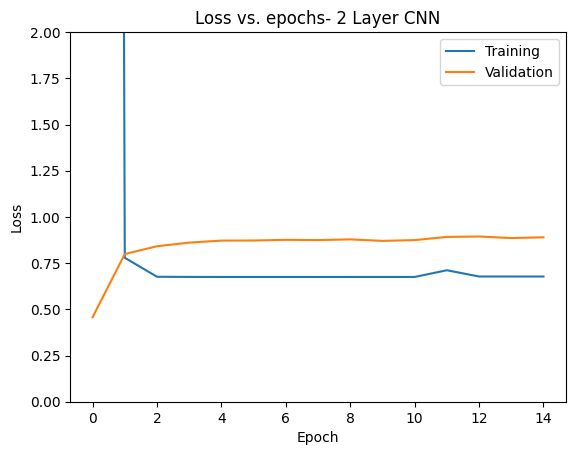

In [ ]:
#Plotting the loss vs epoch graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs- 2 Layer CNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.ylim(0, 2)
plt.show()

In [ ]:
# Import classification report
from sklearn.metrics import classification_report

# Make predictions on test set
test_preds = model.predict(X_test_processed)
test_preds = test_preds.argmax(axis=1)

# Print classification report
print("2 Layer CNN:")
print(classification_report(y_test_encoded, test_preds, zero_division=1))

44/44 [==============================] - 1s 13ms/step
2 Layer CNN:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       375
           1       0.73      1.00      0.85      1023

    accuracy                           0.73      1398
   macro avg       0.87      0.50      0.42      1398
weighted avg       0.80      0.73      0.62      1398



44/44 [==============================] - 1s 15ms/step


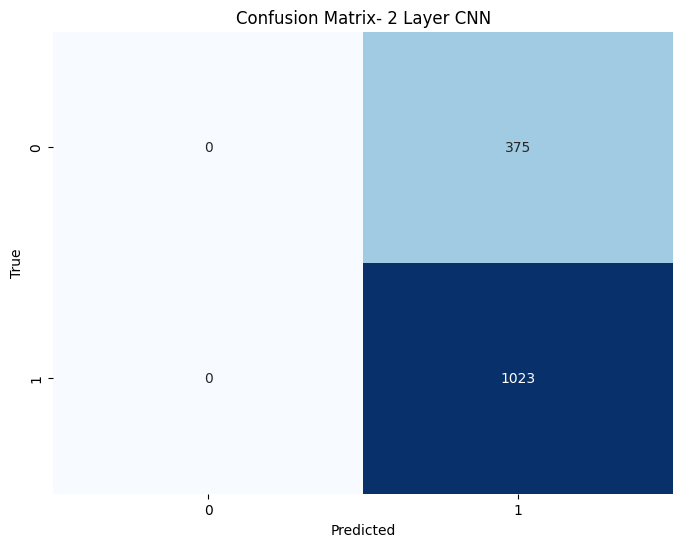

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted labels for the test set
y_pred = model.predict(X_test_processed)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix- 2 Layer CNN')
plt.show()

44/44 [==============================] - 1s 13ms/step


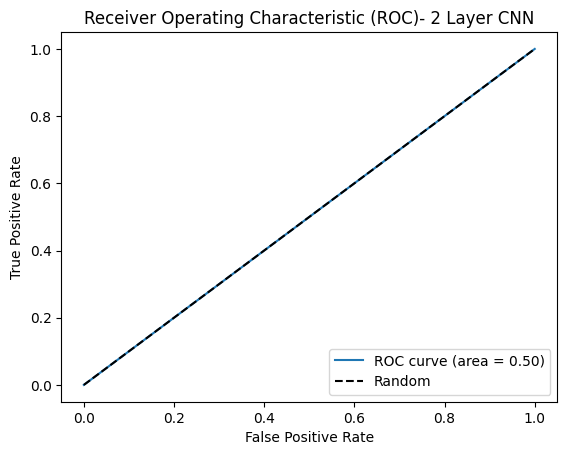

AUC: 0.50


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get the model predictions
y_pred_prob = model.predict(X_test_processed)
y_pred = np.argmax(y_pred_prob, axis=1)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_prob[:, 1])
auc = roc_auc_score(y_test_encoded, y_pred_prob[:, 1])

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)- 2 Layer CNN')
plt.legend(loc='lower right')
plt.show()

# Print AUC score
print("AUC: {:.2f}".format(auc))

Four CNN layers with Regularisation

In [ ]:
weight_decay= 0.001
dropout_rate=0.3
# Define the model architecture
model2_reg = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3), kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer='he_uniform', bias_initializer='ones'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    tf.keras.layers.Dense(2, activation='softmax')
])

checkpoint_best_path= 'model_checkpoints_best/checkpoint'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                                 save_weights_only=True,
                                 save_freq='epoch',
                                 monitor='val_loss',
                                 save_best_only=True,
                                 verbose=1)
early_stopping= tf.keras.callbacks.EarlyStopping(patience=3)
learning_rate_reduction= tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.2, patience=5, verbose=2)

opt= tf.keras.optimizers.Adam(learning_rate=0.001)
model2_reg.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])



# Train the model
history1= model2_reg.fit(X_train_balanced, y_train_balanced, batch_size=32, epochs=30, validation_split=0.15, callbacks=[checkpoint_best, early_stopping, learning_rate_reduction])

# Evaluate the model on the test set
test_loss, test_accuracy = model2_reg.evaluate(X_test_processed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/30
218/218 [==============================] - ETA: 0s - loss: 32.0799 - accuracy: 0.5800
Epoch 1: val_loss improved from inf to 2.24873, saving model to model_checkpoints_best/checkpoint
218/218 [==============================] - 37s 149ms/step - loss: 32.0799 - accuracy: 0.5800 - val_loss: 2.2487 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/30
217/218 [============================>.] - ETA: 0s - loss: 2.0145 - accuracy: 0.5880
Epoch 2: val_loss improved from 2.24873 to 2.17992, saving model to model_checkpoints_best/checkpoint
218/218 [==============================] - 32s 145ms/step - loss: 2.0144 - accuracy: 0.5883 - val_loss: 2.1799 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/30
217/218 [============================>.] - ETA: 0s - loss: 1.9676 - accuracy: 0.5868
Epoch 3: val_loss improved from 2.17992 to 2.17368, saving model to model_checkpoints_best/checkpoint
218/218 [==============================] - 31s 142ms/step - loss: 1.9676 - accuracy: 0.5870 - val_loss: 2.

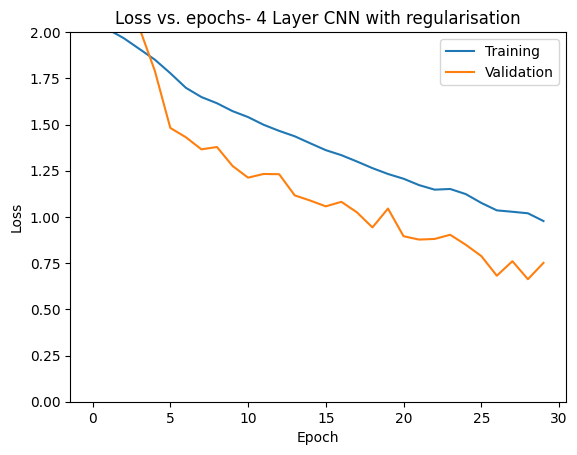

In [ ]:
#Run this cell to plot the epoch vs loss graph
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss vs. epochs- 4 Layer CNN with regularisation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.ylim(0, 2)
plt.show()

In [ ]:
# Import classification report
from sklearn.metrics import classification_report

# Make predictions on test set
test_preds = model2_reg.predict(X_test_processed)
test_preds = test_preds.argmax(axis=1)

# Print classification report
print("4 Layer CNN with regularisation:")
print(classification_report(y_test_encoded, test_preds, zero_division=1))

44/44 [==============================] - 1s 18ms/step
4 Layer CNN with regularisation:
              precision    recall  f1-score   support

           0       0.29      0.01      0.01       375
           1       0.73      1.00      0.84      1023

    accuracy                           0.73      1398
   macro avg       0.51      0.50      0.43      1398
weighted avg       0.61      0.73      0.62      1398



44/44 [==============================] - 1s 17ms/step


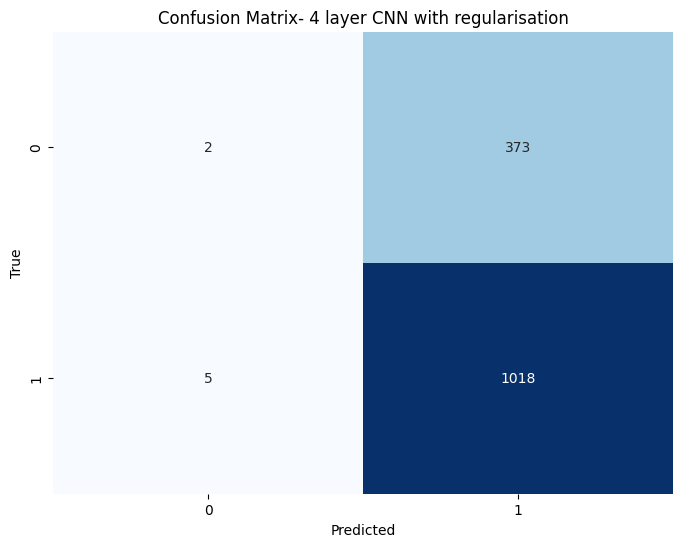

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted labels for the test set
y_pred = model2_reg.predict(X_test_processed)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix- 4 layer CNN with regularisation')
plt.show()

44/44 [==============================] - 1s 17ms/step


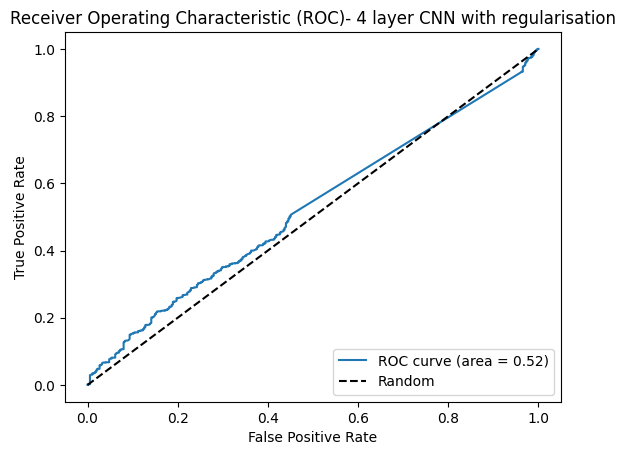

AUC: 0.52


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get the model predictions
y_pred_prob = model2_reg.predict(X_test_processed)
y_pred = np.argmax(y_pred_prob, axis=1)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_prob[:, 1])
auc = roc_auc_score(y_test_encoded, y_pred_prob[:, 1])

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)- 4 layer CNN with regularisation')
plt.legend(loc='lower right')
plt.show()

# Print AUC score
print("AUC: {:.2f}".format(auc))

DenseNet121 pretrained model

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the CheXNet model without the top (classification) layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add a global average pooling layer to reduce the spatial dimensions
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a dense (fully connected) layer for classification
x = Dense(512, activation='relu')(x)

# Add the output layer with the number of classes
output = Dense(2, activation='softmax')(x)

# Create the CheXNet model with the modified top layers
chexNet_model_new = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers (optional)
for layer in base_model.layers:
    layer.trainable = False

checkpoint_best_path= 'model_checkpoints_chexNet_model/checkpoint'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                                 save_weights_only=False,
                                 save_freq='epoch',
                                 monitor='val_loss',
                                 save_best_only=True,
                                 verbose=1)

# Compile the model
chexNet_model_new.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history_chexNet_model_new= chexNet_model_new.fit(X_train_balanced, y_train_balanced, batch_size=32, epochs=30, validation_split=0.15, callbacks=[checkpoint_best])

# Evaluate the model on the test set
test_loss, test_accuracy = chexNet_model_new.evaluate(X_test_processed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
np.save(HOME+'history_densnet.npy', history_chexNet_model_new)


29084464/29084464 [==============================] - 2s 0us/step
Epoch 1/30
218/218 [==============================] - ETA: 0s - loss: 1.3383 - accuracy: 0.6324
Epoch 1: val_loss improved from inf to 0.27796, saving model to model_checkpoints_chexNet_model/checkpoint


218/218 [==============================] - 93s 378ms/step - loss: 1.3383 - accuracy: 0.6324 - val_loss: 0.2780 - val_accuracy: 0.8339
Epoch 2/30
217/218 [============================>.] - ETA: 0s - loss: 0.6765 - accuracy: 0.6666
Epoch 2: val_loss did not improve from 0.27796
218/218 [==============================] - 29s 134ms/step - loss: 0.6761 - accuracy: 0.6670 - val_loss: 0.3711 - val_accuracy: 0.7932
Epoch 3/30
217/218 [============================>.] - ETA: 0s - loss: 0.6959 - accuracy: 0.6649
Epoch 3: val_loss improved from 0.27796 to 0.21973, saving model to model_checkpoints_chexNet_model/checkpoint


218/218 [==============================] - 76s 348ms/step - loss: 0.6958 - accuracy: 0.6651 - val_loss: 0.2197 - val_accuracy: 0.8526
Epoch 4/30
217/218 [============================>.] - ETA: 0s - loss: 0.5892 - accuracy: 0.6960
Epoch 4: val_loss improved from 0.21973 to 0.16772, saving model to model_checkpoints_chexNet_model/checkpoint


218/218 [==============================] - 75s 344ms/step - loss: 0.5892 - accuracy: 0.6959 - val_loss: 0.1677 - val_accuracy: 0.9259
Epoch 5/30
217/218 [============================>.] - ETA: 0s - loss: 0.5697 - accuracy: 0.7041
Epoch 5: val_loss did not improve from 0.16772
218/218 [==============================] - 30s 136ms/step - loss: 0.5700 - accuracy: 0.7041 - val_loss: 0.3007 - val_accuracy: 0.8062
Epoch 6/30
217/218 [============================>.] - ETA: 0s - loss: 0.5565 - accuracy: 0.7170
Epoch 6: val_loss did not improve from 0.16772
218/218 [==============================] - 29s 135ms/step - loss: 0.5563 - accuracy: 0.7173 - val_loss: 0.3928 - val_accuracy: 0.7549
Epoch 7/30
217/218 [============================>.] - ETA: 0s - loss: 0.5672 - accuracy: 0.7081
Epoch 7: val_loss did not improve from 0.16772
218/218 [==============================] - 28s 129ms/step - loss: 0.5671 - accuracy: 0.7081 - val_loss: 0.2400 - val_accuracy: 0.8420
Epoch 8/30
217/218 [===============

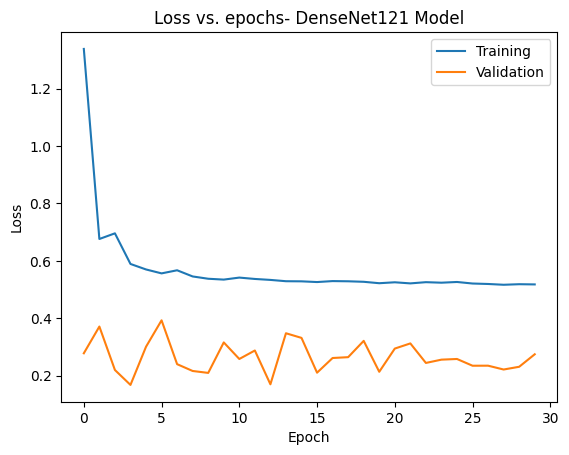

In [ ]:
#Run this cell to plot the epoch vs loss graph
plt.plot(history_chexNet_model_new.history['loss'])
plt.plot(history_chexNet_model_new.history['val_loss'])
plt.title('Loss vs. epochs- DenseNet121 Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Import classification report
from sklearn.metrics import classification_report

# Make predictions on test set
test_preds = chexNet_model_new.predict(X_test_processed)
test_preds = test_preds.argmax(axis=1)

# Print classification report
print("DenseNet121 Model:")
print(classification_report(y_test_encoded, test_preds, zero_division=1))

44/44 [==============================] - 6s 101ms/step
DenseNet121 Model:
              precision    recall  f1-score   support

           0       0.27      0.05      0.08       375
           1       0.73      0.96      0.83      1023

    accuracy                           0.71      1398
   macro avg       0.50      0.50      0.45      1398
weighted avg       0.61      0.71      0.63      1398



44/44 [==============================] - 4s 99ms/step


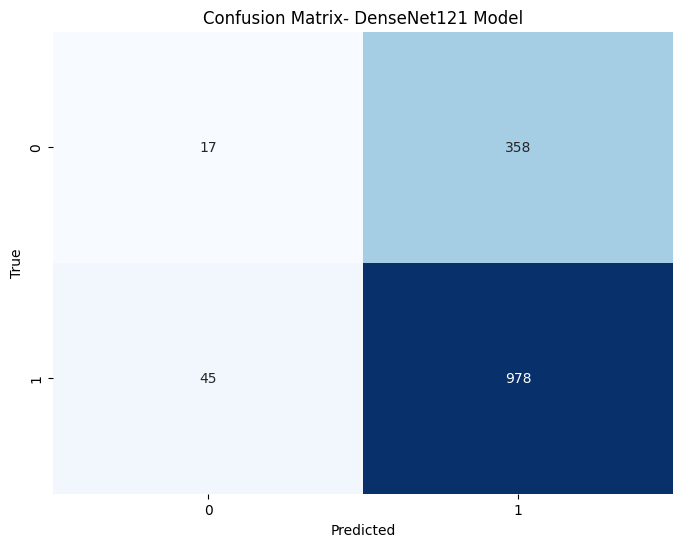

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

# Get the predicted labels for the test set
y_pred = chexNet_model_new.predict(X_test_processed)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix- DenseNet121 Model')
plt.show()

44/44 [==============================] - 4s 99ms/step


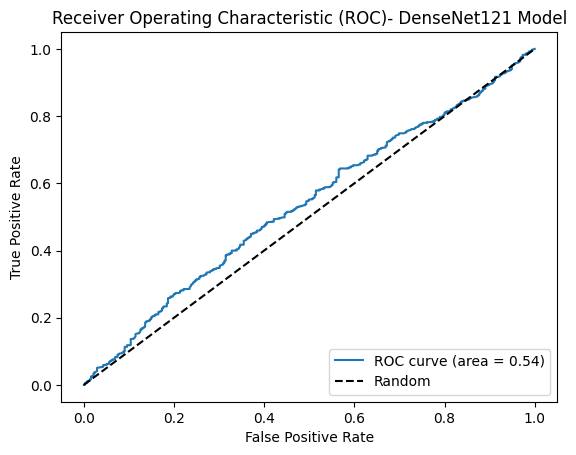

AUC: 0.54


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get the model predictions
y_pred_prob = chexNet_model_new.predict(X_test_processed)
y_pred = np.argmax(y_pred_prob, axis=1)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_prob[:, 1])
auc = roc_auc_score(y_test_encoded, y_pred_prob[:, 1])

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)- DenseNet121 Model')
plt.legend(loc='lower right')
plt.show()

# Print AUC score
print("AUC: {:.2f}".format(auc))


In [ ]:
chexNet_model_new.save(HOME+'chexNet_30epoch_lr_001_latest.hd5')